<a href="https://colab.research.google.com/github/drsimonturega/high_content_quantum_yield/blob/main/HCQY_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High content quantum yield calculator

In [13]:
# @title Enter the lab book code for this experiemnt
# @markdown ## Enter the name of the PS used in this experiment
lab_book_code = 'TPP' # @param {type:"string"}
os.mkdir(lab_book_code)

FileExistsError: [Errno 17] File exists: 'TPP'

### Upload absorbtion file (*.csv export from a bmg plate reader)



In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Abs280224C11SHUTPP.csv to Abs280224C11SHUTPP.csv
Saving Fl280224C11SHUTPP.csv to Fl280224C11SHUTPP.csv
User uploaded file "Abs280224C11SHUTPP.csv" with length 121838 bytes
User uploaded file "Fl280224C11SHUTPP.csv" with length 92771 bytes


In [4]:
filename = next(iter(uploaded))
print(filename)

hcqy__dat_Abs280224C11SHUTPP.csv


In [ ]:
# @title collecting parameters for analysis
# @markdown ## Enter the name of the PS used in this experiment
Standard PS = 'TPP' # @param {type:"string"}
PS one  = 'TPP' # @param {type:"string"}
PS two = 'TPP' # @param {type:"string"}
PS three = 'TPP' # @param {type:"string"}
# @markdown ## Enter quantum yield value the standard PS
qy  = 0.11 # @param {type:"number"}

### Upload flourescence file (*.csv export from a bmg plate reader)

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving hcqy__dat_Fl280224C11SHUTPP.csv to hcqy__dat_Fl280224C11SHUTPP.csv
User uploaded file "hcqy__dat_Fl280224C11SHUTPP.csv" with length 156721 bytes


HCQY for TPP


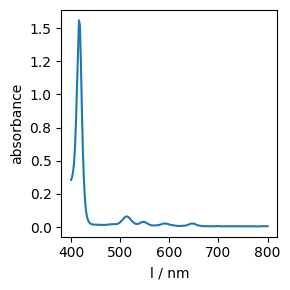

HCQY for TPP


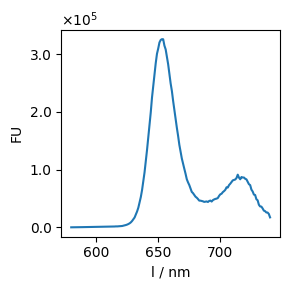

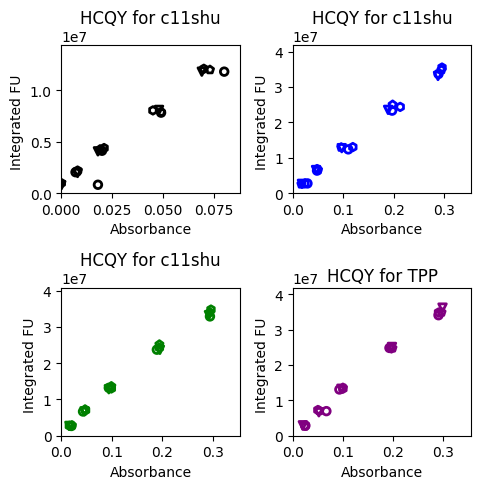

Table 1, Quantum yield values
| PS     |        Φf |           σ |         2σ |   % error at σ |   % error at 2σ |
|--------|-----------|-------------|------------|----------------|-----------------|
| c11shu | 0.0751945 | 0.00234331  | 0.00468661 |        3.11633 |         6.23265 |
| c11shu | 0.074322  | 0.00266562  | 0.00533124 |        3.58658 |         7.17316 |
| c11shu | 0.0777619 | 0.000817601 | 0.0016352  |        1.05141 |         2.10283 |

Table 2, QC report
| PS     | pippetteing error   | plot linearity   | Φf % error   |
|--------|---------------------|------------------|--------------|
| TPP    | True                | False            |              |
| c11shu | True                | True             | True         |
| c11shu | True                | True             | True         |
| c11shu | True                | False            | True         |
HCQY for c11shu


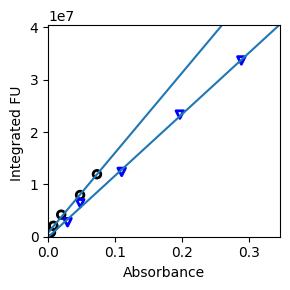

HCQY for c11shu


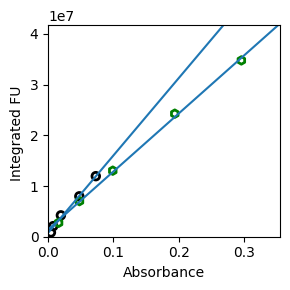

HCQY for c11shu


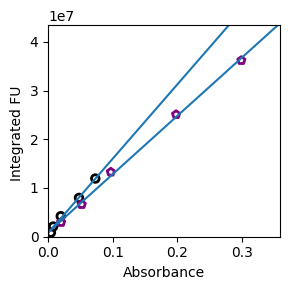

In [8]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LinearRegression
import statistics
from tabulate import tabulate

class ScalarFormatterClass(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"


class hcqy_exp_to_value():


    def __init__(self, abs_input, flu_input, st_qy, ps_lst, exp_points, num_ps,
        num_rep, abs_wav_len_start, exc_wav_len):
        return

    def spec_import(self, spec_sht_name):
        #importing spectra from clariostar output
        spec_inp= pd.DataFrame()
        try:
            spec_inp = pd.read_csv(spec_sht_name + '.csv')
        except PermissionError:
            print('The file we are trying to open may be open in another \
                program, please close and try again!')
        try: #transpose and remove some columns, these may need changeing
            spec_inp = pd.DataFrame.transpose(spec_inp)
            spec_inp = spec_inp.drop(axis=1, columns=[0,1,2,3])
            #print(_inp)
        except KeyError:
            print('Check the your input file!')
        try:    #_inp.sort_index()
            spec_inp = spec_inp.reset_index(drop=True)
            #build well name and remove related columns
            spec_inp.iloc[0:,1] = spec_inp.iloc[0:,1].astype(str)
            spec_inp.iloc[0:,2] = (spec_inp.iloc[0:,0].astype(str)
                + spec_inp.iloc[0:,1].astype(str))
            spec_inp = spec_inp.drop(axis=1, columns=[4,5])
            spec_inp = pd.DataFrame.drop(spec_inp,axis=0, index=0)
            spec_inp.iloc[0,0] = "Well"
        except IndexError:
            print('Check the your input file!')
        try:
            # set row 0 as col titles
            spec_inp.rename(columns= spec_inp.iloc[0,0:], inplace=True)
            spec_inp = spec_inp.reset_index(drop=True)
            spec_inp = pd.DataFrame.drop(spec_inp, axis=0, index=0)
            spec_inp = spec_inp.reset_index(drop=True)
        except KeyError:
            print('Check the your input file!')
        #calculate and subtract back ground
        tdf = spec_inp.iloc[[0,6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72,
            78, 84, 90]].drop(["Well"], axis = 1).apply(pd.to_numeric)
        tdf = tdf.mean(axis = 0, numeric_only = True)
        tdf = tdf.to_frame().transpose().round(3)
        spec_inp.iloc[0:,1:] = spec_inp.iloc[0:,1:].apply(pd.to_numeric) - tdf.values.squeeze()
        try: #output results
            spec_inp.to_csv("hcqy__dat_" + spec_sht_name + ".csv",index=False)
        except PermissionError:
            print('The file we are trying to open may be open in another \
                program, please close and try again!')

        return spec_inp
    def rep_spec(self,spec_inp, y_lab, dat_inp, ps_lst ):
        # gives a representative plot
        # make a transposed frame for plotting ???
        spec_plot = spec_inp.transpose()
        header = spec_plot.iloc[0]
        spec_plot = spec_plot[1:]
        spec_plot.columns = header
        spec_plot = spec_plot.apply(pd.to_numeric)
        #print(spec_plot.head())
        fig = plt.figure(figsize=(3,3))
        #plt.title(f'HCQY for {ps_lst[0]}', pad=5)
        x_1 = list(map(int,(spec_plot.index)))
        #y_1 = "B3"
        #plt.xticks(x_1,len(spec_plot.index), 10)
        plt.plot(x_1, spec_plot["A2"])
        ax = plt.gca()
        plt.xlabel("l / nm")
        yScalarFormatter = ScalarFormatterClass(useMathText=True)
        yScalarFormatter.set_powerlimits((0,0))
        ax.yaxis.set_major_formatter(yScalarFormatter)
        plt.ylabel(y_lab)
        fig.tight_layout()
        plt.ticklabel_format(style='sci', axis='y')
        print(f'HCQY for {ps_lst[0]}')
        fig.savefig(f'rep_{y_lab}spec_for_{ps_lst[0]}.png', dpi = 100)
        plt.show()

    def plot_calc(self, abs_inp, flu_inp, ps_lst, exp_points, num_ps, num_rep,
            abs_wav_len_start, exc_wav_len):
        #seting up output file
        now = datetime.now()
        with open(f'hcqy_out.txt', "w", encoding="utf-8") as f: \
            f.write(f'HCQY {now.strftime("%d/%m/%Y %H:%M:%S")}\nStandard PS'
            f'is {str(ps_lst[0])}\nUnknown PS are {str(ps_lst[1])}, '
            f'{str(ps_lst[2])} and {str(ps_lst[0])}.\n' )
        # setup columns
        hcqy_plot= pd.DataFrame()
        hcqy_plot.insert(0,"PS", range(0,(exp_points*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_plot.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]
        # define excitation wavelength
        exc_col_num = int((exc_wav_len - abs_wav_len_start) / 2)
        # populates experiemnt names and data point names
        # add abs values at excitation wavelength
        hcqy_plot["ex_abs_1"], hcqy_plot["ex_abs_2"], hcqy_plot[
            "ex_abs_3"], hcqy_plot["ex_abs_4"]  = [0, 0, 0, 0]
        hcqy_plot["ex_int_flu_1"], hcqy_plot["ex_int_flu_2"], hcqy_plot[
            "ex_int_flu_3"], hcqy_plot["ex_int_flu_4"]  = [0, 0, 0, 0]
        #selecting columns to convet to numeric using df.columns
        try:
            cols = abs_inp.columns.drop('Well')
            abs_inp[cols] = abs_inp[cols].apply(pd.to_numeric, errors='coerce')
        except ValueError:
            print('Their may be extra lines in your absorbance input file')
        # add abs values at excitation wavelength
        for x in range(0,(num_rep)):
            for p in range(0,len(ps_lst)):
                #print(p*exp_points)
                n=0
                g = 0
                if p >= 2:
                    g=36
                while n <= (exp_points-1):
                    hcqy_plot.iloc[(p*exp_points+n),x+1] = abs_inp.iloc[
                        (p*exp_points+n+1+p+x*12+g),exc_col_num]
                    n = n +1
        #selecting columns to convet to numeric using df.columns
        try:
            cols = flu_inp.columns.drop('Well')
            flu_inp[cols] = flu_inp[cols].apply(pd.to_numeric, errors='coerce')
        except ValueError:
            print('Their may be extra lines in your flourecsence input file')
        # populate integrated fluorescence intensities
        for x in range(0,(num_rep)):
            for p in range(0,len(ps_lst)):
                #print(p*exp_points)
                n=0
                g = 0
                if p >= 2:
                    g=36
                while n <= (exp_points-1):
                    hcqy_plot.iloc[(p*exp_points+n),x+5] = flu_inp.iloc[(p
                        *exp_points+n+1+p+x*12+g),1:].sum()
                    n = n +1
        # generate overarching plots, raw abd vs. int flu labled
        mark_lst = ["o", "v", "h", "p"]
        colour_lst = ["black", "blue", "green", "purple"]
        fig, ax = plt.subplots(2, 2, figsize=(5,5))
        #loops to generate number of PS * number of repeats plots
        for p in range(0,len(ps_lst)):
            if p == 0 or p == 1:
                px = 0
            else:
                px = 1
            if p == 0 or p == 2:
                py = 0
            else:
                py = 1
            plt.title(f'HCQY for {ps_lst[p]}', pad=5)
            for x in range(0,(num_rep)):
                # plot design
                x_1 = hcqy_plot.iloc[p*5:(5+p*5),x+1]
                y_1 = hcqy_plot.iloc[p*5:(5+p*5),x+5]
                plt.subplot(2, 2, p+1)
                ax[px,py].scatter(x_1, y_1,s=30, facecolors='none', edgecolors
                    =colour_lst[p], linewidths=2.0, marker = mark_lst[x])
                plt.xlim(0,(1.2*max(x_1)))
                plt.ylim(0,(1.2*max(y_1)))
                plt.xlabel("Absorbance")
                plt.ylabel("Integrated FU ")
        fig.tight_layout()
        plt.show()
        return hcqy_plot

    def hcqy_grads(self, hcqy_plot, exp_points, ps_lst, num_ps, num_rep):
         # set up gradiant data frame with experiemnt by experiemnt possitions
        hcqy_grad = pd.DataFrame()
        hcqy_grad.insert(0,"PS", range(0,(num_rep*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_grad.iloc[(p*num_rep):(p*(num_rep))+num_rep] = ps_lst[p]
        hcqy_grad["grad_abs_flu"]  = 0
        hcqy_grad["grad_R^2"]  = 0
        hcqy_grad["grad_intercept"]  = 0
        hcqy_grad["flu_QY"]  = 0
        # populate gradiant data frame
        for p in range(0,len(ps_lst)):
            #per PS
            for x in range(0,(num_rep)):
                #per rep
                x_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+1]).reshape((-1, 1))
                y_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+5])
                qy_grad = LinearRegression().fit(x_lr, y_lr)
                hcqy_grad.iloc[x+p*num_rep,1] =  qy_grad.coef_[0]
                hcqy_grad.iloc[x+p*num_rep,2] =  qy_grad.score(x_lr, y_lr)
                hcqy_grad.iloc[x+p*num_rep,3] =  qy_grad.intercept_
        return hcqy_grad

    def hcqy_qy_calc(self, hcqy_grad, exp_points, ps_lst, num_ps, num_rep):
        # prep for QY calc collect standard QY values and check solvents
        # take mean of standard gradient
        st_grad = statistics.mean(hcqy_grad.iloc[0:4,1])
        # calculate QYs move to QY df
        st_qy = 0.1 # check value
        for p in range(1,len(ps_lst)):
            #per PS
            for x in range(0,(num_rep)):
                #per rep
                hcqy_grad.iloc[x+p*num_rep,4] = st_qy * ((hcqy_grad.iloc[x
                    +p*num_rep,1])/st_grad)*(1**2/1**2)
        hcqy_qy = pd.DataFrame()
        hcqy_qy.insert(0,"PS", range(0,num_ps-1))
        hcqy_qy["\u03A6f"]  = 0
        hcqy_qy["\u03C3"]  = 0
        hcqy_qy["2\u03C3"]  = 0
        hcqy_qy["% error at \u03C3"]  = 0
        hcqy_qy["% error at 2\u03C3"]  = 0
        for p in range(1,len(ps_lst)):
            hcqy_qy.iloc[(p-1),0] = ps_lst[p]
            hcqy_qy.iloc[(p-1),1] = statistics.mean(hcqy_grad.iloc[p
                *4:p*4+5,4])
            hcqy_qy.iloc[(p-1),2] = statistics.stdev(hcqy_grad.iloc[p
                *4:p*4+5,4])
            hcqy_qy.iloc[(p-1),3] = 2 * hcqy_qy.iloc[(p-1),2]
            hcqy_qy.iloc[(p-1),4] = (hcqy_qy.iloc[(p-1),2]
                / hcqy_qy.iloc[(p-1),1]) * 100
            hcqy_qy.iloc[(p-1),5] = (hcqy_qy.iloc[(p-1),3]
                / hcqy_qy.iloc[(p-1),1]) * 100
        hcqy_qy = hcqy_qy.reset_index(drop=True)
        print("Table 1, Quantum yield values")
        qy_tab = tabulate(hcqy_qy, headers=hcqy_qy.columns,
            tablefmt="github", showindex=False)
        print(qy_tab)
        with open(f'hcqy_out.txt', "a", encoding="utf-8") as f: f.write(f'\
            \nTable 1, Quantum yield values\n{qy_tab}\nAvailible \
            as hcqy_values.csv\n')
        try: #output results
            hcqy_qy.to_csv(f'hcqy_values.csv',index=False)
        except PermissionError:
            print('The file we are trying to open may be open in another \
            program, please close and try again!')
        return hcqy_qy

    def hcqy_qc(self, hcqy_plot, hcqy_qy, hcqy_grad, exp_points, \
            ps_lst, num_ps, num_rep):
        # global QC frame
        hcqy_qc_df = pd.DataFrame()
        # plot information, setup columns
        hcqy_qc_df.insert(0,"PS", range(0,num_ps))
        for p in range(0,len(ps_lst)):
            hcqy_qc_df.iloc[p] = ps_lst[p]
        # build replicate data frame
        hcqy_rep_df = pd.DataFrame()
        # setup columns
        hcqy_rep_df.insert(0,"PS", range(0,(exp_points*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_rep_df.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]
        # check replicates with standard devation from average set thresh hold
        hcqy_rep_df["abs_mean"]  = 0
        hcqy_rep_df["abs_\u03C3"]  = 0
        hcqy_rep_df["abs_2\u03C3"]  = 0
        hcqy_rep_df["% error at \u03C3"]  = 0
        hcqy_rep_df["% error at 2\u03C3"]  = 0
        for x in range(0,(exp_points)):
            #per PS
            for p in range(0,(len(ps_lst))):
                #per rep
                hcqy_rep_df.iloc[x+p*exp_points,1] = statistics.mean(
                    hcqy_plot.iloc[x+p*exp_points, 1:5])
                hcqy_rep_df.iloc[x+p*exp_points,2] = statistics.stdev(
                    hcqy_plot.iloc[x+p*exp_points, 1:5])
                hcqy_rep_df.iloc[x+p*exp_points,3] = 2 * hcqy_rep_df.iloc[x
                    +p*exp_points,2]
                hcqy_rep_df.iloc[x+p*exp_points,4] = (hcqy_rep_df.iloc[x+p
                    *exp_points,2] / hcqy_rep_df.iloc[x+p*exp_points,1]) * 100
                hcqy_rep_df.iloc[x+p*exp_points,5] = (hcqy_rep_df.iloc[x+p
                    *exp_points,3] / hcqy_rep_df.iloc[x+p*exp_points,1]) * 100
        # populate QC data frame pipetting error set at 10%
        hcqy_qc_df["pippetteing error"]  = False
        for p in range(0,(len(ps_lst))):
            if max(hcqy_rep_df.iloc[p*exp_points:p*exp_points + 5,5]) >= 10:
                hcqy_qc_df.iloc[p,1]= True
        # Check linear plots with R^2 set thresh hold 10%
        hcqy_qc_df["plot linearity"]  = True
        for p in range(0,(len(ps_lst))):
            if min(hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]) <= 0.99: #
                hcqy_qc_df.iloc[p,2]= False
         # check error in QY set average and populate QC data frame
        hcqy_qc_df["\u03A6f % error"]  = ""
        for p in range(1,(len(ps_lst))):
            if hcqy_qy.iloc[p-1,5] >= 10: # thresh hold set at 10%
                hcqy_qc_df.iloc[p,3]= False
            else:
                hcqy_qc_df.iloc[p,3]= True
        # save QC report as *.CSV
        qc_tab = tabulate(hcqy_qc_df, headers=hcqy_qc_df.columns,
            tablefmt="github", showindex=False)
        print("\nTable 2, QC report")
        print(qc_tab)
        try: #output results
            with open(f'hcqy_out.txt', "a", encoding
                ="utf-8") as f: f.write(f'\nTable 2, QC report\n{qc_tab}')
        except PermissionError:
            print('The *.txt file we are trying to append may be open in \
            another program, please close and try again!')
        return

    def hcqy_prod_plot(self, hcqy_plot, hcqy_qy, hcqy_grad, exp_points,
            ps_lst, num_ps, num_rep):
        # make plot data frame
        hcqy_plot_df = pd.DataFrame()
        hcqy_plot_df.insert(0,"PS", range(0,(exp_points*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_plot_df.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]
        hcqy_plot_df["rep abs"]  = 0
        hcqy_plot_df["rep flu"]  = 0
        hcqy_plot_df["line flu"]  = 0
        hcqy_plot_df["R^2"]  = 0
        # populate control
        R2_str = "R^2 values; "
        for x in range(0,(exp_points)):
            hcqy_plot_df.iloc[x,1] = statistics.mean(hcqy_plot.iloc[x,1:5])
            hcqy_plot_df.iloc[x,2] = statistics.mean(hcqy_plot.iloc[x,5:9])
            hcqy_plot_df.iloc[x,3] = (hcqy_plot_df.iloc[x,1]
                * statistics.mean(hcqy_grad.iloc[0:4,1])
                + statistics.mean(hcqy_grad.iloc[0:4,3]))
            hcqy_plot_df.iloc[x,4] = hcqy_grad.iloc[pd.Series(
                    hcqy_grad.iloc[0:4,2]).idxmax(),2]
        R2_str = R2_str + f'{ps_lst[0]} = {str(round(hcqy_plot_df.iloc[1,4], 4))}'
        # populate representative x selecting repeat with best R^2
        for p in range(1,(len(ps_lst))):
            for x in range(0,(exp_points)):
                hcqy_plot_df.iloc[x + p * exp_points,1] = hcqy_plot.iloc[x
                    + p * exp_points,1 + ((pd.Series(hcqy_grad.iloc[p
                    *num_rep:p*num_rep + 4,2]).idxmax()) - p * num_rep)]
                hcqy_plot_df.iloc[x + p * exp_points,2] = hcqy_plot.iloc[x
                    + p * exp_points,5 + ((pd.Series(hcqy_grad.iloc[p
                    *num_rep:p*num_rep + 4,2]).idxmax()) - p * num_rep)]
                hcqy_plot_df.iloc[x + p * exp_points,3] = hcqy_plot_df.iloc[x
                    + p * exp_points,1] * hcqy_grad.iloc[pd.Series(
                    hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]).idxmax(),1] \
                    + hcqy_grad.iloc[pd.Series(hcqy_grad.iloc[p*num_rep:p
                    *num_rep + 4,2]).idxmax(),3]
                hcqy_plot_df.iloc[x + p * exp_points,4] = hcqy_grad.iloc[pd.Series(
                    hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]).idxmax(),2]
            t_str = (f', {str(hcqy_plot_df.iloc[p * 5,0])}'
                f'= {str(round(hcqy_plot_df.iloc[p * 5,4], 4))}')
            R2_str = R2_str + t_str
        # setup columns generate overarching plots, raw abd vs. int flu labled
        mark_lst = ["o", "v", "h", "p"]
        colour_lst = ["black", "blue", "green", "purple"]
        #loops to generate number of PS * number of repeats plots
        for p in range(1,len(ps_lst)):
            fig = plt.figure(figsize=(3,3))
            print(f'HCQY for {ps_lst[p]}')
            #plt.title(f'HCQY for {ps_lst[p]}', pad=5)
            x_1 = hcqy_plot_df.iloc[0:5,1]
            y_1 = hcqy_plot_df.iloc[0:5,2]
            x_2 = hcqy_plot_df.iloc[p*5:(5+p*5),1]
            y_2 = hcqy_plot_df.iloc[p*5:(5+p*5),2]
            y_3 = hcqy_plot_df.iloc[0:5,3]
            y_4 = hcqy_plot_df.iloc[p*5:(5+p*5),3]
            plt.scatter(x_1, y_1,s=30, facecolors='none', edgecolors
                =colour_lst[0], linewidths = 2.0, marker = mark_lst[0])
            plt.axline(xy1 = (hcqy_plot_df.iloc[0,1],hcqy_plot_df.iloc[0,3]),
                xy2 = (hcqy_plot_df.iloc[4,1],hcqy_plot_df.iloc[4,3]))
            plt.scatter(x_2, y_2,s=30, facecolors='none', edgecolors
                =colour_lst[p], linewidths=2.0, marker = mark_lst[p])
            plt.axline(xy1 = (hcqy_plot_df.iloc[(p*5),1],hcqy_plot_df.iloc[(p
                *5),3]), xy2 = (hcqy_plot_df.iloc[(4+p*5),1],
                hcqy_plot_df.iloc[(4+p*5),3]))
            plt.xlim(0,(1.2*max(x_2)))
            plt.ylim(0,(1.2*max(y_2)))
            plt.xlabel("Absorbance")
            plt.ylabel("Integrated FU ")
            fig.tight_layout()
            fig.savefig(f'hcqy{p}_for_{ps_lst[p]}.png', dpi = 100)
            plt.show()
        try: #R^2 values
            with open(f'hcqy_out.txt', "a",
                      encoding="utf-8") as f: f.write(f'\n{R2_str}')
        except PermissionError:
            print('The *.txt file we are trying to append may be open in \
            another program, please close and try again!')
        return

def analyse_hcqy(abs_input, flu_input, st_qy, ps_lst, abs_wav_len_start, exc_wav_len):
    #This is the function that runs the scripts
    # user input these are standard inputs
    # name of abs input file from clario star
    #abs_input = "Abs280224C11SHUTPP"
    # name of flu input file from clario star
    #flu_input = "Fl280224C11SHUTPP"
    # standard
    #st_qy = 0.11 # check value
    # PS being used the first one is standard
    #ps_lst = ["TPP","c11shu","c11shu","c11shu"]
    # inpout values used less often
    exp_points = 5
    num_ps = 4
    num_rep = 4
    #abs_wav_len_start = 400
    #exc_wav_len = 516
    # set up experiment
    val_calc = hcqy_exp_to_value(abs_input, flu_input, st_qy, ps_lst, exp_points,
        num_ps, num_rep, abs_wav_len_start, exc_wav_len)
    #load spectra fles
    abs_inp = hcqy_exp_to_value.spec_import(val_calc, abs_input)
    hcqy_exp_to_value.rep_spec(abs_inp, abs_inp, "absorbance", abs_input, ps_lst)
    flu_inp = hcqy_exp_to_value.spec_import(val_calc, flu_input)
    hcqy_exp_to_value.rep_spec(flu_inp, flu_inp, "FU", flu_input, ps_lst)
    # Initial plot
    plot_one = hcqy_exp_to_value.plot_calc(val_calc,abs_inp, flu_inp, ps_lst,
        exp_points, num_ps, num_rep, abs_wav_len_start, exc_wav_len)
    # calculayr graiants
    plot_grd = hcqy_exp_to_value.hcqy_grads(val_calc, plot_one, exp_points,
        ps_lst, num_ps, num_rep)
    # QY calculation
    plot_qy = hcqy_exp_to_value.hcqy_qy_calc(val_calc, plot_grd, exp_points,
        ps_lst, num_ps, num_rep)
    # QY QC
    qc_one = hcqy_exp_to_value.hcqy_qc(val_calc, plot_one, plot_qy, plot_grd,
        exp_points, ps_lst, num_ps, num_rep)
    # QY representative plots
    pc_one = hcqy_exp_to_value.hcqy_prod_plot(val_calc, plot_one, plot_qy,
        plot_grd, exp_points, ps_lst, num_ps, num_rep)

    return


analyse_hcqy("Abs280224C11SHUTPP", "Fl280224C11SHUTPP", 0.11, ["TPP","c11shu","c11shu","c11shu"],400, 516 )

In [14]:
ls


Abs280224C11SHUTPP.csv  hcqy3_for_c11shu.png              hcqy_values.csv                 TPP/
Fl280224C11SHUTPP.csv   hcqy__dat_Abs280224C11SHUTPP.csv  rep_absorbancespec_for_TPP.png
hcqy1_for_c11shu.png    hcqy__dat_Fl280224C11SHUTPP.csv   rep_FUspec_for_TPP.png
hcqy2_for_c11shu.png    hcqy_out.txt                      sample_data/
